# Complex Model Interpretability - Model-Agnostic Reason Codes

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np                   # array, vector, matrix calculations
import pandas as pd                  # DataFrame handling

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, r2_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb                # gradient boosting machines (GBMs)
from xgboost import plot_importance

import matplotlib.pyplot as plt      # plotting

pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline        

## Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. 

### All Input variables are numeric and will be used as is (no transformations) for simplicity/interpretability purposes. This should not be the approach if maximizing model performance is the goal.

#### Import data and clean
The credit card default data is available as an `.csv` file. Pandas reads `.csv` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [2]:
# import csv file
path = './default_of_credit_card_clients.csv'
data = pd.read_csv(path) 

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

print("Data dimensions:", data.shape)
print(data.head(5))
print(data.dtypes)

Data dimensions: (30000, 25)
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2       3913       3102        689          0          0   
1      0      2       2682       1725       2682       3272       3455   
2      0      0      29239      14027      13559      14331      14948   
3      0      0      46990      48233      49291      28314      28959   
4      0      0       8617       5670      35835      20940      19146   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT

In [3]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

data[X + [y]].describe() # display descriptive statistics for all columns

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [4]:
# check for missing values - none
data.isnull().values.any()

False

### Split into Train/Test randomly

In [5]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.8     # 80%/20% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 23918, columns = 25
Test data rows = 6082, columns = 25


### Train a complex non-linear model with XGBoost (could be any complex model)

In [6]:
%%time

param_grid = {'max_depth': [3, 5], 'learning_rate': [0.01, 0.1, 1.0], 'n_estimators': [100, 500], 'reg_alpha': [0.1, 1], 
              'reg_lambda': [0.1, 1]}

gbcclf = xgb.XGBClassifier(tree_method='hist', subsample=0.9, colsample_bytree=0.9)
gs_clf = GridSearchCV(gbcclf, param_grid, n_jobs=20, cv=5, scoring='roc_auc', refit=True)

gs_clf.fit(train[X], train[y])

print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.7813747547780632
{'reg_alpha': 1, 'reg_lambda': 1, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 5}
CPU times: user 7.04 s, sys: 224 ms, total: 7.26 s
Wall time: 53.7 s


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.84      0.95      0.89      4718
          1       0.68      0.38      0.49      1364

avg / total       0.81      0.82      0.80      6082

[[4477  241]
 [ 842  522]]
AUC: 0.7847685720998634
Top10 Feature ranking:
1. feature BILL_AMT1 	(0.093043)
2. feature LIMIT_BAL 	(0.084553)
3. feature AGE 	(0.067987)
4. feature PAY_AMT1 	(0.064122)
5. feature PAY_AMT3 	(0.062742)
6. feature PAY_AMT2 	(0.060050)
7. feature PAY_AMT5 	(0.050870)
8. feature PAY_AMT6 	(0.050663)
9. feature PAY_AMT4 	(0.047488)
10. feature BILL_AMT6 	(0.047004)


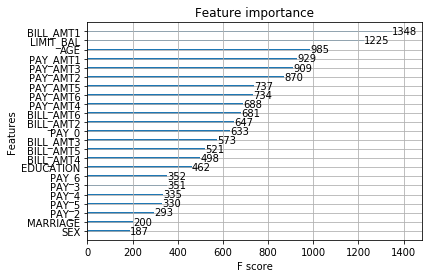

In [7]:
# evaluate on true TEST
preds = gs_clf.best_estimator_.predict(test[X])
probs = gs_clf.best_estimator_.predict_proba(test[X])

print(classification_report(test[y],preds))
print(confusion_matrix(test[y],preds))
print("AUC:", roc_auc_score(test[y], probs[:, 1]))

importances = gs_clf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1][:20]

# Print the feature ranking
print("Top10 Feature ranking:")
for f in range(10):
    print("%d. feature %s \t(%f)" % (f + 1, train[X].columns[indices[f]], importances[indices[f]]))
    
# plot feature importance
plot_importance(gs_clf.best_estimator_)

#### The above feature importance is on a global XGBoost level and isn't useful for explaining individual predictions. 

### ASIDE: Compare to standard Scikit-learn GBM which uses a different way for global feature importance calculation

In [8]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

param_grid = {'max_depth': [3, 5], 'learning_rate': [0.01, 0.1, 1.0], 'n_estimators': [100, 500]}

gbm_sl = GradientBoostingClassifier()

gbm_sl_clf = GridSearchCV(gbm_sl, param_grid, n_jobs=20, cv=5, scoring='roc_auc', refit=True)

gbm_sl_clf.fit(train[X], train[y])

print(gbm_sl_clf.best_score_)
print(gbm_sl_clf.best_params_)

0.7793594455435782
{'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 5}
CPU times: user 34.3 s, sys: 100 ms, total: 34.4 s
Wall time: 1min 45s


In [9]:
# evaluate on true TEST
preds_gbm = gbm_sl_clf.best_estimator_.predict(test[X])
probs_gbm = gbm_sl_clf.best_estimator_.predict_proba(test[X])

print(classification_report(test[y],preds_gbm))
print(confusion_matrix(test[y],preds_gbm))
print("AUC:", roc_auc_score(test[y], probs_gbm[:, 1]))

importances = gbm_sl_clf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1][:20]

# Print the feature ranking
print("Top10 Feature ranking:")
for f in range(10):
    print("%d. feature %s \t(%f)" % (f + 1, train[X].columns[indices[f]], importances[indices[f]]))

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      4718
          1       0.68      0.38      0.49      1364

avg / total       0.80      0.82      0.80      6082

[[4468  250]
 [ 840  524]]
AUC: 0.7849743883473662
Top10 Feature ranking:
1. feature PAY_0 	(0.245240)
2. feature BILL_AMT1 	(0.081368)
3. feature LIMIT_BAL 	(0.054927)
4. feature AGE 	(0.050296)
5. feature PAY_AMT5 	(0.048116)
6. feature PAY_AMT1 	(0.043298)
7. feature PAY_AMT2 	(0.041580)
8. feature BILL_AMT2 	(0.041139)
9. feature PAY_AMT6 	(0.037710)
10. feature BILL_AMT3 	(0.036922)


In [10]:
# check individual correlation of feature with target- seems the GBM variable importance approach leads to more intuitive results
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1]

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


## How to generate model-agnostic LOCAL reason codes

In [11]:
# cbind predictions to test frame
# give them a nice name
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = pd.concat([test['ID'], pd.Series(data=probs[:,1], index=test.index)], axis=1)
preds1.columns = ['ID', yhat]
test_yhat = pd.concat([test, preds1[yhat]], axis = 1)
test_yhat.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.662796
6,7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0,0.075374
11,12,260000,2,1,2,51,-1,-1,-1,-1,-1,2,12261,21670,9966,8517,22287,13668,21818,9966,8583,22301,0,3640,0,0.082151
16,17,20000,1,1,2,24,0,0,2,2,2,2,15376,18010,17428,18338,17905,19104,3200,0,1500,0,1650,0,1,0.538173
17,18,320000,1,1,1,49,0,0,0,-1,-1,-1,253286,246536,194663,70074,5856,195599,10358,10000,75940,20000,195599,50000,0,0.110598


## Build a Surrogate Model - linear model on original features to predict the scores/predictions of the complex model

In [12]:
reg = Ridge(alpha = 0.01)

reg.fit(test_yhat[X], test_yhat[yhat])
y_pred = reg.predict(test_yhat[X])
print("R^2 of the linear model:", r2_score(test_yhat[yhat], y_pred))

R^2 of the linear model: 0.5783250008530778


### Surrogate model fit is not great based on R^2 but let's go with it

In [13]:
# Print the coefficients - PAY_0 and PAY_2 most important globally
intercept = reg.intercept_
coeffs = reg.coef_
print("Feature coefficients:")
print("INTERCEPT", "\t", intercept)
for f in range(len(coeffs)):
    print(X[f], "\t", coeffs[f])

Feature coefficients:
INTERCEPT 	 0.29107421333184214
LIMIT_BAL 	 -5.044303665233025e-08
SEX 	 -0.0067064629593093245
EDUCATION 	 -0.013311309441279376
MARRIAGE 	 -0.014668452009165533
AGE 	 0.0011863485394621642
PAY_0 	 0.09688645111606227
PAY_2 	 0.02573988625024672
PAY_3 	 0.007923756627030905
PAY_4 	 0.0061335871846485744
PAY_5 	 0.005793542468188125
PAY_6 	 0.0003018209932357377
BILL_AMT1 	 -6.290514937514963e-07
BILL_AMT2 	 2.1578656082333253e-07
BILL_AMT3 	 -2.966597432758352e-07
BILL_AMT4 	 9.268001483484364e-08
BILL_AMT5 	 -1.5077336827623143e-07
BILL_AMT6 	 3.3513874806930496e-07
PAY_AMT1 	 -5.108898672407233e-07
PAY_AMT2 	 8.226291932785825e-08
PAY_AMT3 	 -1.7937875112673315e-07
PAY_AMT4 	 -1.479041396926578e-07
PAY_AMT5 	 -6.753513630294556e-07
PAY_AMT6 	 -1.3253753668349482e-07


### Print the row of a very risky customer

In [14]:
row = test_yhat[test_yhat['ID'] == 22760]
row

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
22759,22760,460000,2,1,1,40,3,2,2,3,3,3,2650,2650,2650,2650,2650,2650,0,0,0,0,0,200,1,0.855318


### Get the complex model prediction PLUS top local Reason Codes (in real time)

In [15]:
def get_reason_codes(data, complex_model, surr_model, columns = X):
    probs = complex_model.predict_proba(data)
    print("Predicted probability of default:", probs[0,1])
    partials = np.multiply(data.values, surr_model.coef_)
    #print("Partals: ",partials)
    #print("Partials in desc order indices: ", (-partials).argsort())

    top_idx = (-partials).argsort()[0][:3]
    #print("\nTop reason code indices", top_idx)

    i = 0
    for f in top_idx:
        i+=1
        print("ReasonCode",i,": ", X[f], "\t", partials[0][f])
        

get_reason_codes(row[X], gs_clf.best_estimator_, reg, X)

Predicted probability of default: 0.85531765
ReasonCode 1 :  PAY_0 	 0.2906593533481868
ReasonCode 2 :  PAY_2 	 0.05147977250049344
ReasonCode 3 :  AGE 	 0.04745394157848657


## Generate reason codes using the LOCO method (in near real time)

#### Calculate LOCO (Leave One Covariate Out) reason values for each record
To implement LOCO, the complex model, e.g. GBM, predicitions are calculated once for the test data and then again for each input variable, setting the entire input variable column to missing. Once the prediction without the variable is found for every row of data in the test set, that column vector of predictions on corrupted data can be subtracted from the column vector of predictions on the original, non-corrupted data to estimate the local contribution of that variable for each prediction in the test data. 

In [16]:
def get_reason_codes_loco(data, complex_model, columns = X):
    probs = complex_model.predict_proba(data)
    print("Predicted probability of default:", probs[0,1])
    
    # calculate LOCO for each variable
    probs2 = np.zeros(len(X))
    for k, i in enumerate(X):
        # pertrub one feature and get prediction with complex model again
        data_loco = data.copy(deep = True)
        data_loco[i] = np.nan
        probs_loco = complex_model.predict_proba(data_loco)
    
        # subtract the LOCO prediction from the original prediction
        probs2[k] = probs[0,1] - probs_loco[0,1]
        
    top_idx = (-probs2).argsort()[:3]
    i = 0
    for f in top_idx:
        i+=1
        print("ReasonCode",i,": ", X[f], "\t", probs2[f])
        

get_reason_codes_loco(row[X], gs_clf.best_estimator_, X)

Predicted probability of default: 0.85531765
ReasonCode 1 :  PAY_0 	 0.2603302001953125
ReasonCode 2 :  BILL_AMT1 	 0.1383494734764099
ReasonCode 3 :  PAY_6 	 0.05674433708190918
